# Customer Churn Risk Modelling
## Swan Teleco
> Project by Danny Burrowes, Lydia Drabkin-Reiter, Ollie Hanlon, Katie Kitchen.

This notebook explores the data provided by SWAN Teleco, drawing insights on the types of customers who churn and the reasons why they leave. Within this notebook, four different machine learning models are used to predict whether a consumer will churn or not. After conducting model evaluations, we concluded that our **logistic regression model** and **sklearn random forest model** were the most robust and accurate. Therefore, a combination of these two models were used to make our final predictions.

In [ ]:
# Importing all modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from time import time
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


In [ ]:
# Seaborn style settings
sns.set_style("whitegrid")
sns.set_context("notebook")
sns.set_palette("Spectral_r")

In [ ]:
# This function checks if the location of the environment is google colab
def is_this_colab():
    location = get_ipython().__class__.__module__
    assert('google.colab._shell' == location), "You must only run this in google colab"
    return True ## Is only triggered unless the assertion is raised

is_this_colab()

True

# 1. EDA


## 1.1 Loading dataframe

In [ ]:
df = pd.read_excel('1 - Project Data.xlsx') # reads in data set

In [ ]:
pd.set_option('display.max_columns', None) # option to view all the columns in a df

In [ ]:
df.head() # reads first 5 rows of df

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,2967-MXRAV,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,Yes,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,18.80,18.8,No,0,NaN
1,9318-NKNFC,1,United States,California,Twain,95984,"40.022184, -121.062384",40.022184,-121.062384,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,18.85,18.85,Yes,1,Service dissatisfaction
2,8992-CEUEN,1,United States,California,Arnold,95223,"38.32153, -120.236358",38.321530,-120.236358,Female,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,18.85,18.85,No,0,NaN
3,9975-SKRNR,1,United States,California,Sierraville,96126,"39.559709, -120.345639",39.559709,-120.345639,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,18.90,18.9,No,0,NaN
4,1423-BMPBQ,1,United States,California,Anaheim,92808,"33.850452, -117.726668",33.850452,-117.726668,Female,No,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,19.00,19,No,0,NaN


In [ ]:
# Checking datatypes for each column
df.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Reason          object
dtype: object

## 1.2 Null handling

In [ ]:
# Checking for null values
df.isnull().sum(); # 5174 nulls in 'churn reason', due to customer not churning
df.fillna('N/A', inplace=True) # fill with flag

In [ ]:
# Finding empty strings in Total Charges
empty_strings = df[df['Total Charges'].str.contains('\D', na=False)] # finding empty strings
print(f'There are {len(empty_strings)} empty strings in the Total Charges column')

There are 11 empty strings in the Total Charges column


In [ ]:
df['Total Charges'] = df['Total Charges'].replace({' ':0}) # replace with 0 as tenure length of all 11 entries is 0 (no payments have been made yet)
df['Total Charges'].astype(float) # change data type to numerical

0       18.80
1       18.85
2       18.85
3       18.90
4       19.00
        ...  
7038     0.00
7039     0.00
7040     0.00
7041     0.00
7042     0.00
Name: Total Charges, Length: 7043, dtype: float64

## 1.3 Checking data cleanliness



In [ ]:
# Showing all unique values for each column
for column in df.columns:
    unique_entries = df[column].unique()
    print(f"Unique entries in {column}:\n{unique_entries}\n")

Unique entries in CustomerID:
['2967-MXRAV' '9318-NKNFC' '8992-CEUEN' ... '2923-ARZLG' '4075-WKNIU'
 '2775-SEFEE']

Unique entries in Count:
[1]

Unique entries in Country:
['United States']

Unique entries in State:
['California']

Unique entries in City:
['Los Angeles' 'Twain' 'Arnold' ... 'South Gate' 'Gualala' 'Alamo']

Unique entries in Zip Code:
[90003 95984 95223 ... 95445 92107 94507]

Unique entries in Lat Long:
['33.964131, -118.272783' '40.022184, -121.062384' '38.32153, -120.236358'
 ... '38.848082, -123.50608' '32.741852, -117.243453'
 '37.855717, -121.994813']

Unique entries in Latitude:
[33.964131 40.022184 38.32153  ... 38.848082 32.741852 37.855717]

Unique entries in Longitude:
[-118.272783 -121.062384 -120.236358 ... -118.192615 -123.50608
 -117.243453]

Unique entries in Gender:
['Male' 'Female']

Unique entries in Senior Citizen:
['No' 'Yes']

Unique entries in Partner:
['Yes' 'No']

Unique entries in Dependents:
['No' 'Yes']

Unique entries in Tenure Months:
[ 1 

> All categorical entries are clean.

## 1.4 Visualisations

### 1.41 Correlation Heatmap between Numerical Features


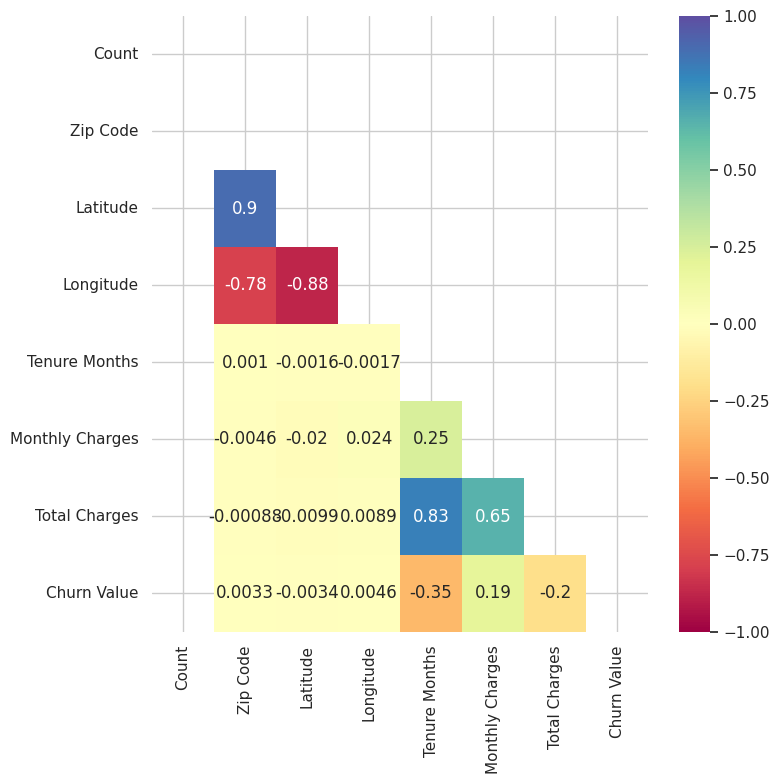

In [ ]:
# Plotting initial correlation heatmap
plt.figure(figsize = (8, 8))
sns.heatmap(df.corr(numeric_only=True),
            annot = True,
            vmin=-1,
            vmax=1,
            cmap ="Spectral",
            mask = np.triu(df.corr(numeric_only=True)))

plt.show()

Here we can see a slight correlation between Tenure Months, Monthly Charges and Total Charges with regards to Churn Value.


### 1.42 Distribution of Monthly Charges for Existing Customers and those who Churned


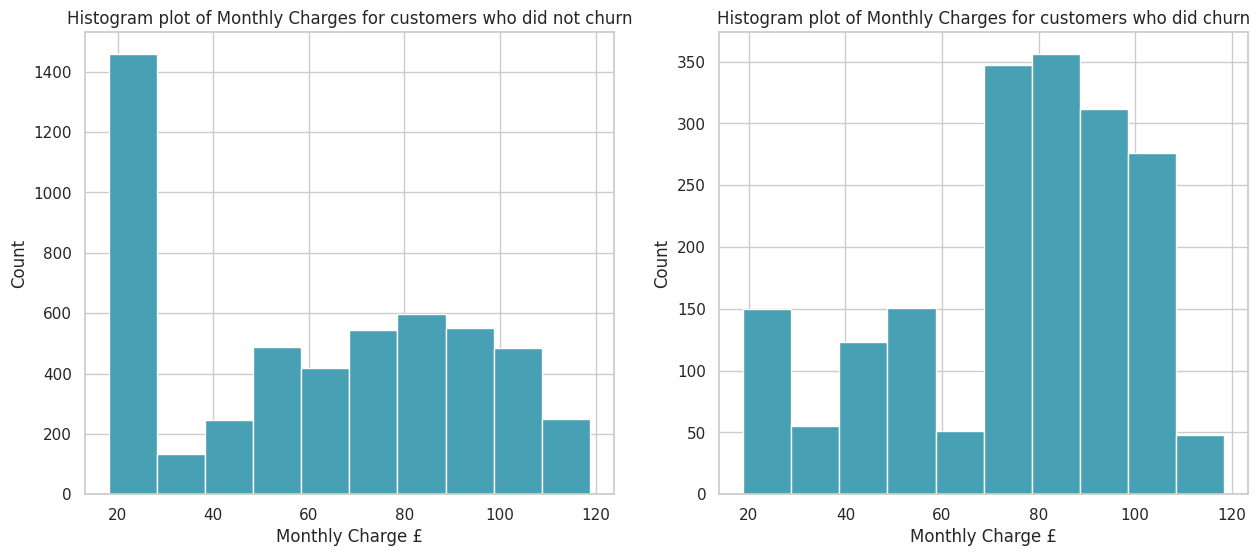

In [ ]:
# Plotting histograms of monthly plot charges split by churn value.
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].hist(data = df[df['Churn Value']==0], x = 'Monthly Charges')
axes[0].set_title('Histogram plot of Monthly Charges for customers who did not churn')
axes[0].set_xlabel('Monthly Charge £')
axes[0].set_ylabel('Count')

axes[1].hist(data = df[df['Churn Value']==1], x = 'Monthly Charges')
axes[1].set_title('Histogram plot of Monthly Charges for customers who did churn')
axes[1].set_xlabel('Monthly Charge £')
axes[1].set_ylabel('Count')
plt.show()

The figures above show customers who Churned were much more likely to have a higher monthly charge.


### 1.43 Distribution of Tenure Charges for Existing Customers and those who Churned

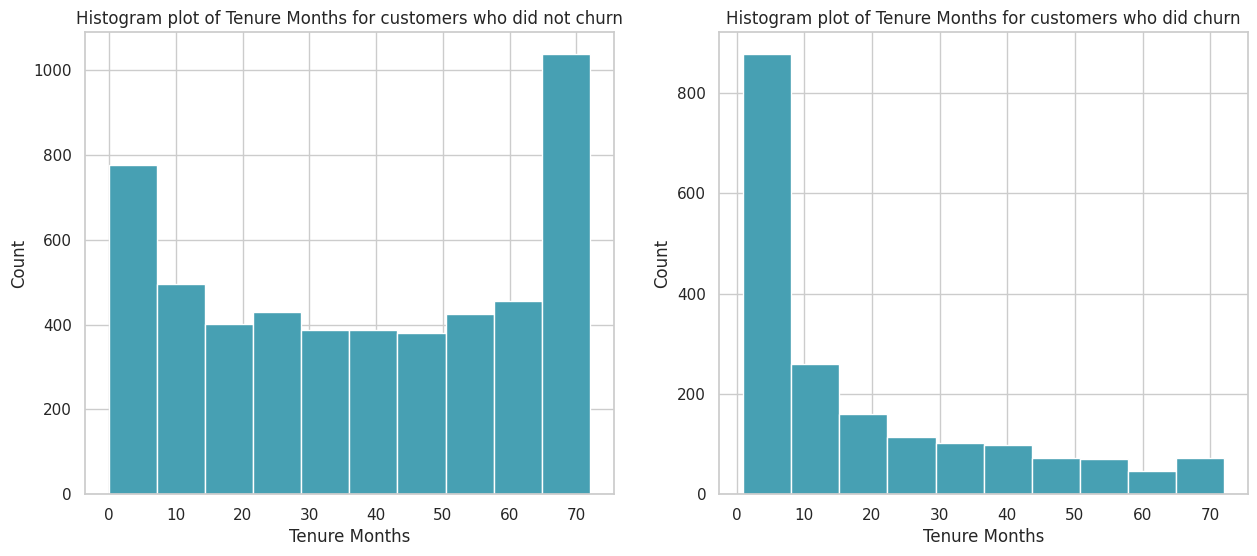

In [ ]:
# Plotting histograms of Tenure Months split by churn value.
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].hist(data = df[df['Churn Value']==0], x = 'Tenure Months')
axes[0].set_title('Histogram plot of Tenure Months for customers who did not churn')
axes[0].set_xlabel('Tenure Months')
axes[0].set_ylabel('Count')

axes[1].hist(data = df[df['Churn Value']==1], x = 'Tenure Months')
axes[1].set_title('Histogram plot of Tenure Months for customers who did churn')
axes[1].set_xlabel('Tenure Months')
axes[1].set_ylabel('Count')
plt.show()

The figures above show customers who churned have had a much shorter tenure period.

### 1.44 Number of Customer by Contract Type and Churn Label


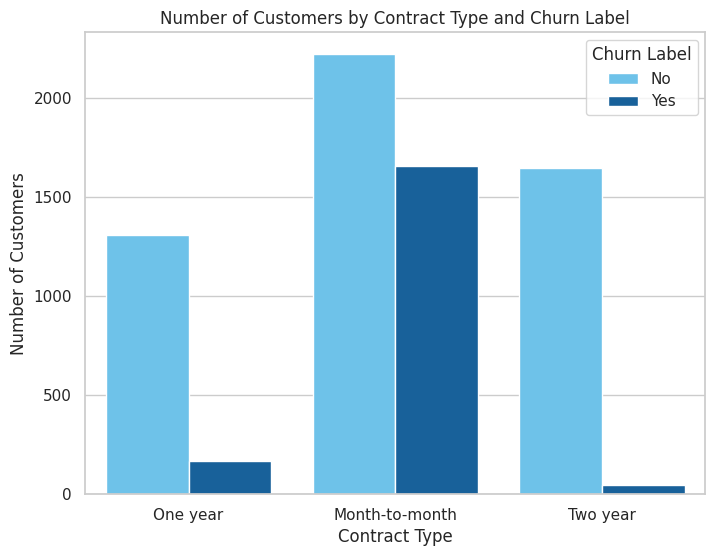

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn's countplot to create a bar graph
sns.countplot(x="Contract", hue="Churn Label", data=df, palette={'Yes': '#0263b0', 'No': '#5acafd'})

# Add labels and title
plt.title('Number of Customers by Contract Type and Churn Label')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.savefig('contract_type.png')
# Show the plot
plt.show()

Customers on a month to month contract type are the most likely to churn. Where as customers on a two year contract are the most likely to stay.

## 1.5 Reasons for Churning


In [ ]:
# Looking at most common reasons for churning.
df_churn = df[df['Churn Value']==1] # Selects dataframe with only customers who churned
df_churn['Churn Reason'].value_counts(normalize=True)

Attitude of support person                   0.102729
Competitor offered higher download speeds    0.101124
Competitor offered more data                 0.086677
Don't know                                   0.082397
Competitor made better offer                 0.074906
Attitude of service provider                 0.072231
Competitor had better devices                0.069556
Network reliability                          0.055110
Product dissatisfaction                      0.054575
Price too high                               0.052434
Service dissatisfaction                      0.047619
Lack of self-service on Website              0.047084
Extra data charges                           0.030498
Moved                                        0.028357
Lack of affordable download/upload speed     0.023542
Limited range of services                    0.023542
Long distance charges                        0.023542
Poor expertise of phone support              0.010701
Poor expertise of online sup

> The reasons of 'Deceased' and 'Moved' have no real reflection on Swan Consulting and may provide false signal in our models. We will remove these from the dataframe.

In [ ]:
# Removing data where reason = Deceased|Moved
df = df[(df['Churn Reason'] != 'Deceased') & (df['Churn Reason'] != 'Moved')]
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,2967-MXRAV,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,Yes,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,18.80,18.80,No,0,N/A
1,9318-NKNFC,1,United States,California,Twain,95984,"40.022184, -121.062384",40.022184,-121.062384,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,18.85,18.85,Yes,1,Service dissatisfaction
2,8992-CEUEN,1,United States,California,Arnold,95223,"38.32153, -120.236358",38.321530,-120.236358,Female,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,18.85,18.85,No,0,N/A
3,9975-SKRNR,1,United States,California,Sierraville,96126,"39.559709, -120.345639",39.559709,-120.345639,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,18.90,18.90,No,0,N/A
4,1423-BMPBQ,1,United States,California,Anaheim,92808,"33.850452, -117.726668",33.850452,-117.726668,Female,No,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,19.00,19.00,No,0,N/A


## 1.6 Checking Class Balance

In [ ]:
# How many customers churned v.s stayed?
print(f'This many passengers churned: {len(df.loc[df["Churn Value"] == 1])}')
print(f'This many passengers stayed: {len(df.loc[df["Churn Value"] == 0])}')

This many passengers churned: 1810
This many passengers stayed: 5174


In [ ]:
# As a fraction
df['Churn Value'].value_counts(normalize=True)

0    0.740836
1    0.259164
Name: Churn Value, dtype: float64

> We ideally want a 50/50 class balance to reduce overtraining on our model. We will look into methods of fixing this later.

# 2. Train Test Splitting

In [ ]:
# Splitting features and target
feature_cols = list(df.columns)
feature_cols.remove('Churn Value')
feature_cols.remove('Churn Label')
feature_cols.remove('Churn Reason')

X = df[feature_cols] # Features/Independent variables
y = df['Churn Value'] # Target/Label/Dependent variables

# Using sklearn to split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
# Checking split
min(X_train.index == y_train.index)
min(X_test.index == y_test.index)

True

In [ ]:
X_train.head() # Checking first 5 rows of X_train

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
4371,6281-FKEWS,1,United States,California,Berry Creek,95916,"39.657228, -121.37778",39.657228,-121.377780,Female,No,No,No,44,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,One year,Yes,Electronic check,49.05,2265.00
2261,7495-OOKFY,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237,Female,Yes,Yes,Yes,8,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Credit card (automatic),80.65,633.30
5397,9978-HYCIN,1,United States,California,Bakersfield,93301,"35.383937, -119.020428",35.383937,-119.020428,Male,Yes,Yes,Yes,47,Yes,No,Fiber optic,No,Yes,No,No,Yes,No,One year,Yes,Bank transfer (automatic),84.95,4018.05
6194,3301-VKTGC,1,United States,California,Huron,93234,"36.217864, -120.080117",36.217864,-120.080117,Male,No,Yes,Yes,68,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,No,One year,Yes,Bank transfer (automatic),85.50,5696.60
2169,4680-KUTAJ,1,United States,California,Beverly Hills,90212,"34.062095, -118.401508",34.062095,-118.401508,Female,Yes,No,No,11,Yes,Yes,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,55.60,580.80


# 3. Feature Engineering


## 3.1 Scaling

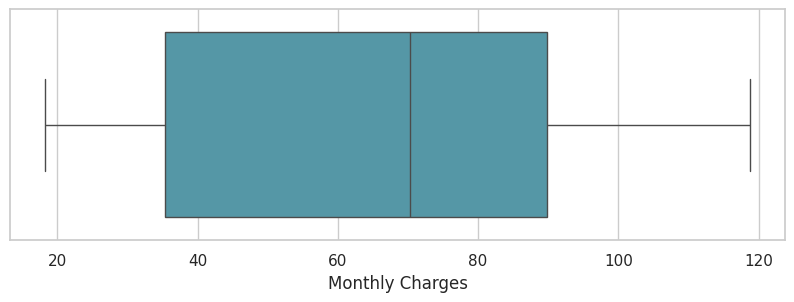

In [ ]:
# Look at distributions of numeric columns (Monthly Charges, Tenure Months and Total Charges).
plt.figure(figsize = (10, 3))
sns.boxplot(data = df['Monthly Charges'],
            orient = 'h')
plt.show()

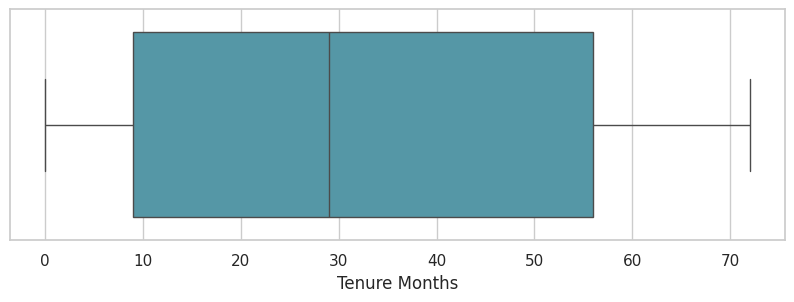

In [ ]:
plt.figure(figsize = (10,3))
sns.boxplot(data = df['Tenure Months'],
            orient = 'h')
plt.show()

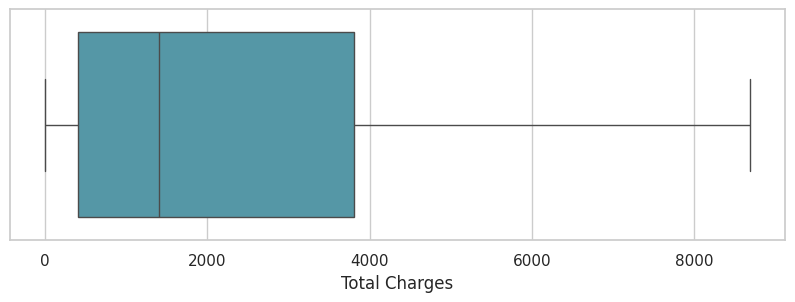

In [ ]:
plt.figure(figsize = (10,3))
sns.boxplot(data = df['Total Charges'],
            orient = 'h')
plt.show()

> There are no outliers, so we will use a MinMaxScaler.

## 3.2 Binary columns

In [ ]:
# Map binary columns into numeric format
df_copy = df.copy()
df_copy['Gender'] = df_copy['Gender'].map({'Male':0, 'Female':1})
yes_no_columns = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service','Paperless Billing']
for column in yes_no_columns:
  df_copy[column] = df_copy[column].map({'No': 0, 'Yes': 1})
df_copy.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,2967-MXRAV,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,0,0,1,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0,Mailed check,18.80,18.80,No,0,N/A
1,9318-NKNFC,1,United States,California,Twain,95984,"40.022184, -121.062384",40.022184,-121.062384,0,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,1,Mailed check,18.85,18.85,Yes,1,Service dissatisfaction
2,8992-CEUEN,1,United States,California,Arnold,95223,"38.32153, -120.236358",38.321530,-120.236358,1,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Electronic check,18.85,18.85,No,0,N/A
3,9975-SKRNR,1,United States,California,Sierraville,96126,"39.559709, -120.345639",39.559709,-120.345639,0,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Mailed check,18.90,18.90,No,0,N/A
4,1423-BMPBQ,1,United States,California,Anaheim,92808,"33.850452, -117.726668",33.850452,-117.726668,1,0,1,1,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,1,Mailed check,19.00,19.00,No,0,N/A


## 3.3 One Hot Encoding

In [ ]:
# Apply OHE to all relevant columns
ohe_cols = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']
for column in ohe_cols:
  df_copy = pd.get_dummies(df, columns=[column], drop_first=True, prefix=column, dtype=int)

## 3.4 Combined function

In [ ]:
# Creating a combined functions
def feature_eng(df):
  ''' function to combine all feature engineering processes for the Swan dataframe.'''
  df = df.copy()
  df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
  yes_no_columns = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service','Paperless Billing']
  for column in yes_no_columns:
      df[column] = df[column].map({'No': 0, 'Yes': 1})
  ohe_cols = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']
  for column in ohe_cols:
      df = pd.get_dummies(df, columns=[column], drop_first=False, prefix=column, dtype=int)
  df['Total Charges'] = df['Total Charges'].replace({' ':0})
  scaler = MinMaxScaler()
  scaler.fit(df[['Tenure Months', 'Monthly Charges', 'Total Charges']])
  df[['Tenure Months', 'Monthly Charges', 'Total Charges']] = scaler.transform(df[['Tenure Months', 'Monthly Charges', 'Total Charges']])
  return df

In [ ]:
# Apply feature engineering to the train
X_train_fe = feature_eng(X_train)
X_train_fe.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Total Charges,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
4371,6281-FKEWS,1,United States,California,Berry Creek,95916,"39.657228, -121.37778",39.657228,-121.377780,1,0,0,0,0.611111,0,1,0.306468,0.260800,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0
2261,7495-OOKFY,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237,1,1,1,1,0.111111,1,1,0.620896,0.072921,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0
5397,9978-HYCIN,1,United States,California,Bakersfield,93301,"35.383937, -119.020428",35.383937,-119.020428,0,1,1,1,0.652778,1,1,0.663682,0.462653,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0


## 3.5 Feature Selections

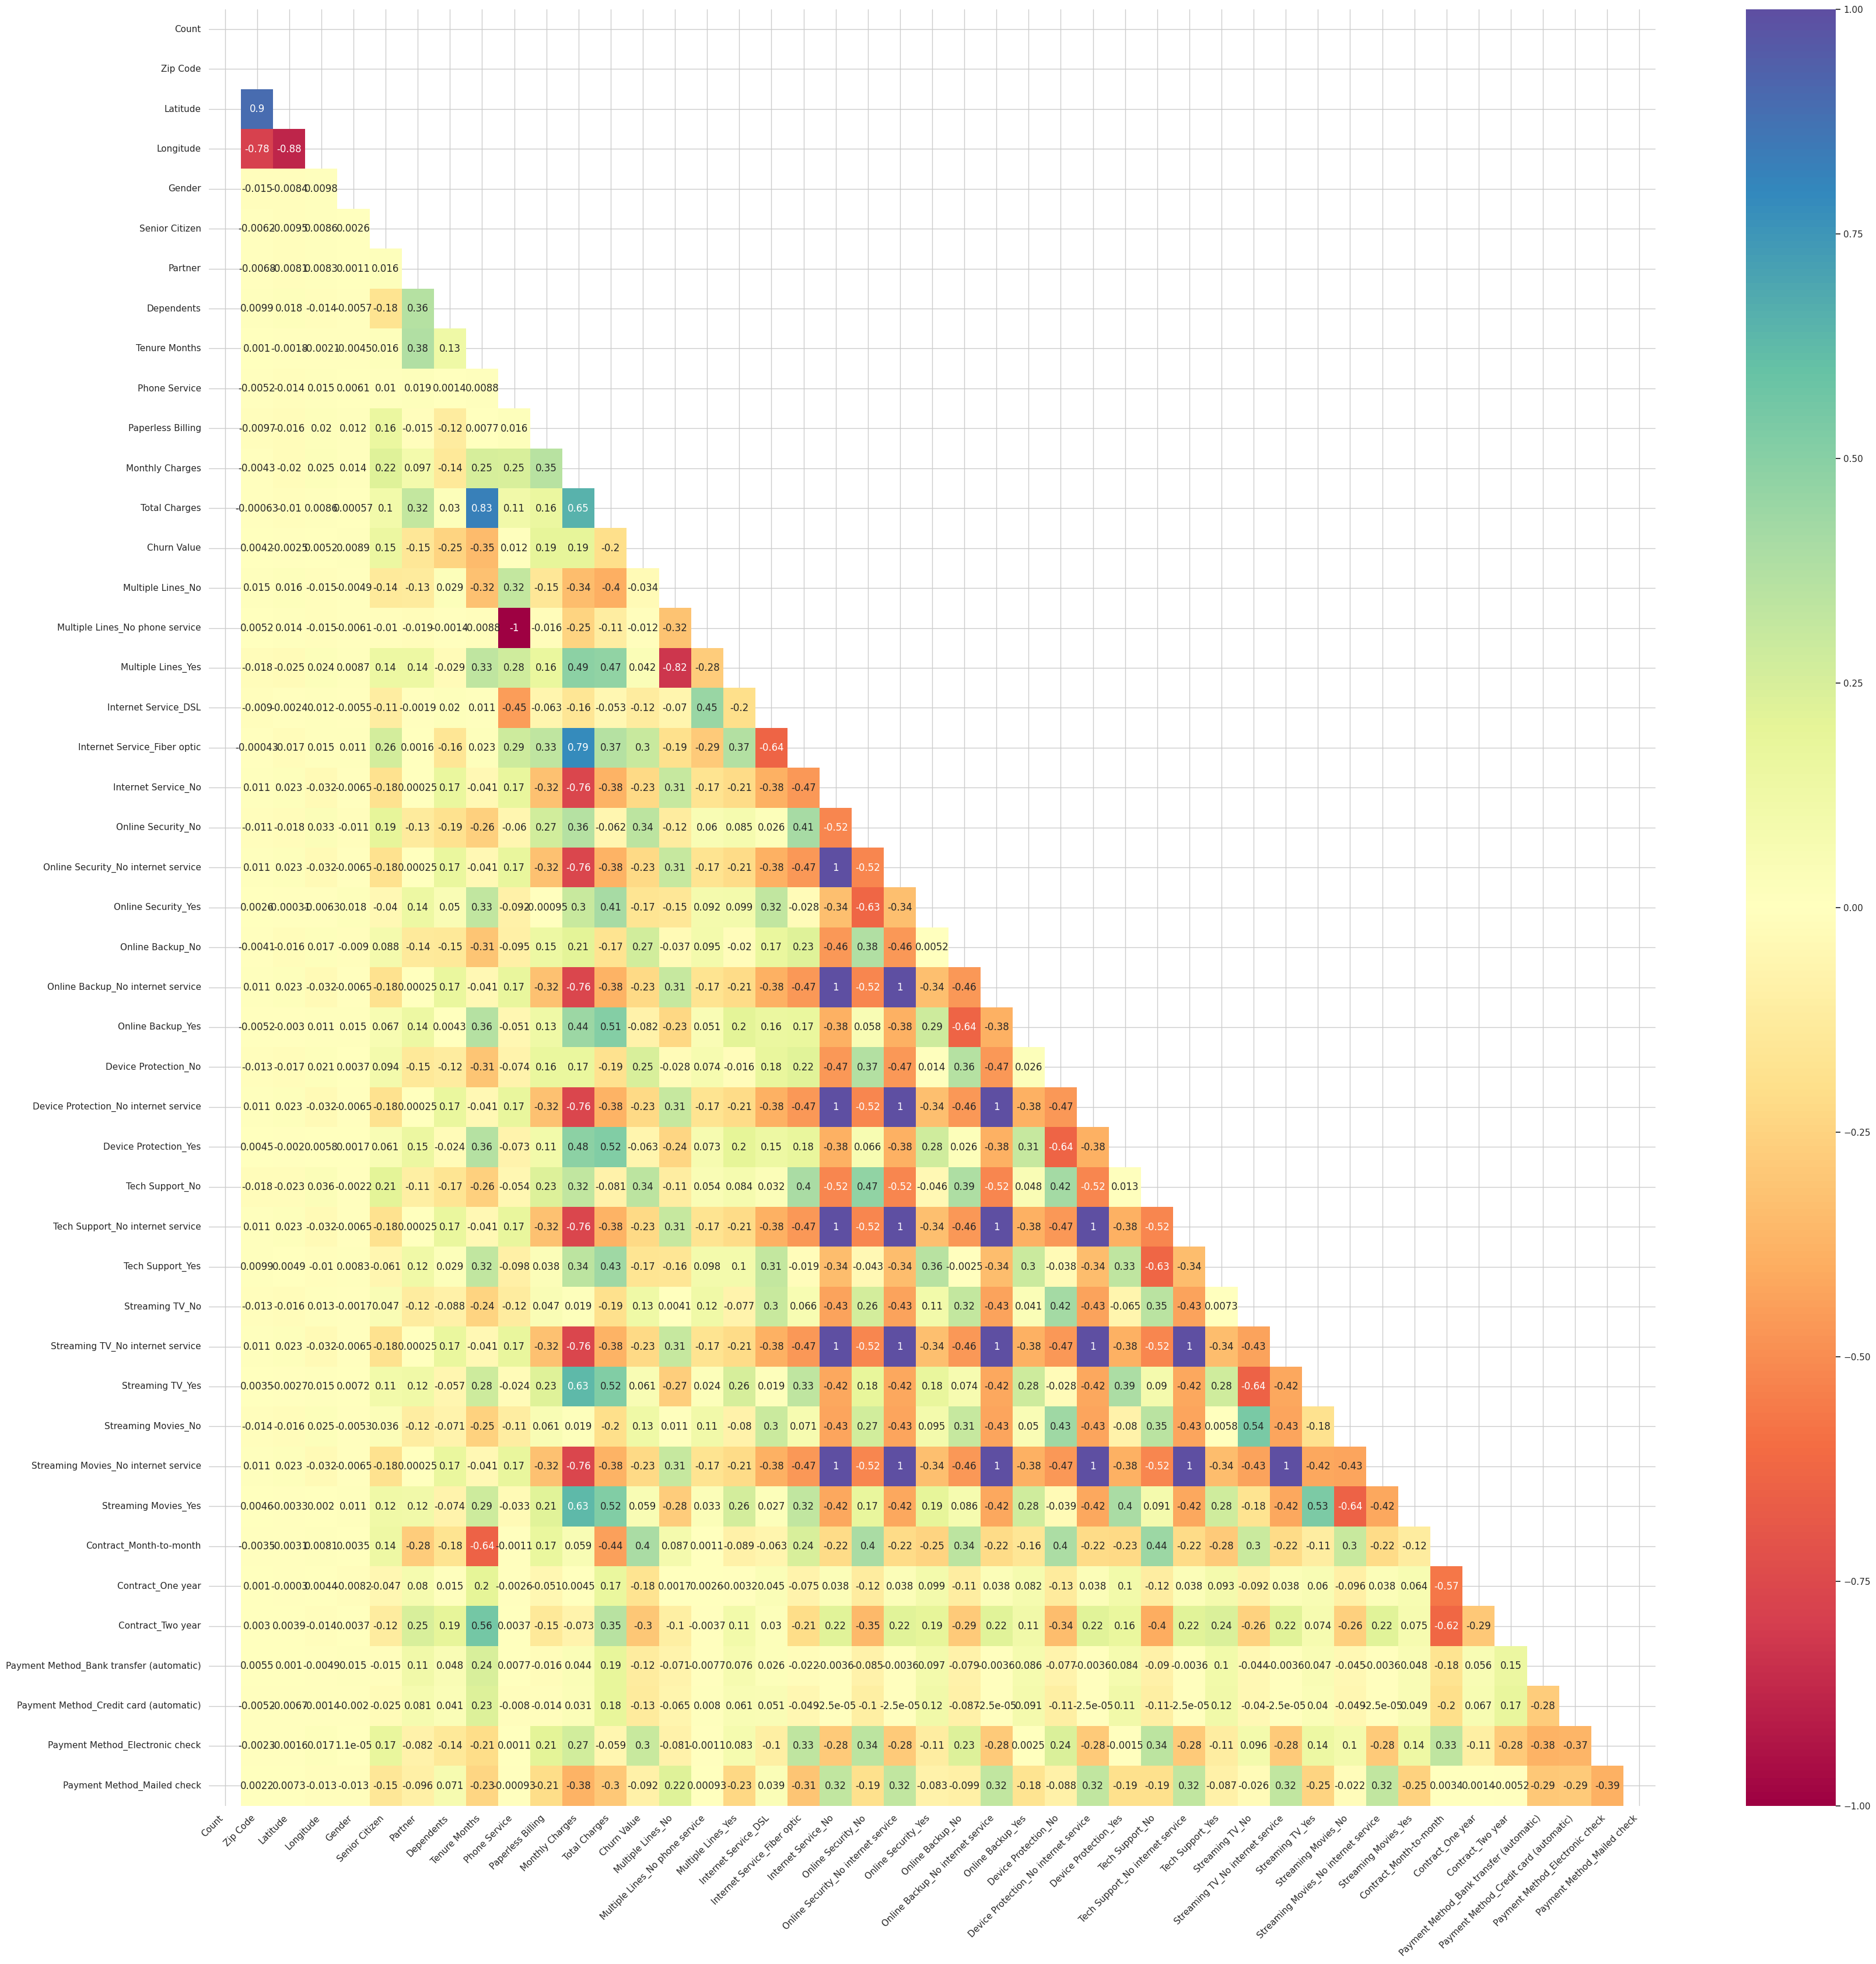

In [ ]:
# Creating a correlation heatmap for all columns
df_fe = feature_eng(df)
plt.figure(figsize = (40, 40))
sns.heatmap(df_fe.corr(numeric_only=True),
            annot = True,
            vmin=-1,
            vmax=1,
            cmap ="Spectral",
            mask = np.triu(df_fe.corr(numeric_only=True)))

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.show()

This gives us an insight into where we will find multicollinearity, and see what features we can immediately discard.
> Let's create a list of features discarding non-numeric columns, and any columns with a correlation of 1 to other features.

In [ ]:
features = ['Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Paperless Billing', 'Monthly Charges', 'Total Charges',
       'Multiple Lines_No', 'Multiple Lines_Yes',
       'Online Security_No', 'Online Security_Yes', 'Online Backup_No', 'Online Backup_Yes',
       'Device Protection_No', 'Device Protection_Yes', 'Tech Support_No',
       'Tech Support_Yes', 'Streaming TV_No', 'Streaming TV_Yes', 'Streaming Movies_No',
       'Streaming Movies_Yes',
       'Internet Service_Fiber optic', 'Internet Service_No',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check']

# This is a list of all features available to use for modelling, to be selected from for each model individually

# 4. Model 1: Logistic Regression

## 4.1 Model Creation and Training

In [ ]:
# Choose features to use
# Create list of all possible features with Churn Value added.
pair_columns = ['Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Paperless Billing', 'Monthly Charges', 'Total Charges',
       'Multiple Lines_No', 'Multiple Lines_Yes',
       'Online Security_No', 'Online Security_Yes', 'Online Backup_No', 'Online Backup_Yes',
       'Device Protection_No', 'Device Protection_Yes', 'Tech Support_No',
       'Tech Support_Yes', 'Streaming TV_No', 'Streaming TV_Yes', 'Streaming Movies_No',
       'Streaming Movies_Yes',
       'Internet Service_Fiber optic', 'Internet Service_No',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check', 'Churn Value']

# Show absolute correlations of features vs. target
df_fe[pair_columns].corr(numeric_only=True)['Churn Value'].abs().sort_values(ascending=False)


Churn Value                               1.000000
Contract_Month-to-month                   0.403415
Tenure Months                             0.349554
Online Security_No                        0.339624
Tech Support_No                           0.336021
Internet Service_Fiber optic              0.304386
Payment Method_Electronic check           0.300460
Contract_Two year                         0.298243
Online Backup_No                          0.266537
Device Protection_No                      0.248388
Dependents                                0.247143
Internet Service_No                       0.225301
Total Charges                             0.196570
Paperless Billing                         0.193387
Monthly Charges                           0.190464
Contract_One year                         0.179197
Online Security_Yes                       0.169558
Tech Support_Yes                          0.165038
Senior Citizen                            0.153068
Partner                        

In [ ]:
# Create new features list of only correlations over |0.15|
model_features = ['Contract_Month-to-month', 'Online Security_No', 'Tenure Months',
                   'Tech Support_No', 'Internet Service_Fiber optic', 'Contract_Two year',
                   'Payment Method_Electronic check', 'Online Backup_No', 'Device Protection_No',
                   'Dependents', 'Internet Service_No', 'Total Charges', 'Monthly Charges',
                   'Paperless Billing', 'Contract_One year', 'Online Security_Yes',
                   'Tech Support_Yes', 'Senior Citizen', 'Partner']

In [ ]:
# Create and train model
logreg = LogisticRegression(max_iter=500, class_weight='balanced')
# max_iter changed from 100 to 400 to allow time for logreg to converge.
# class_weight = 'balanced' used to account for class imbalance.
logreg.fit(X_train_fe[model_features], y_train)

LogisticRegression(class_weight='balanced', max_iter=500)

## 4.2 Generating Predictions

In [ ]:
# Predict probabilities and assign to columns
X_train_fe[['prob_stay1', 'prob_churn1']] = logreg.predict_proba(X_train_fe[model_features])

In [ ]:
# Make predictions using cut-off point
X_train_fe['y_pred1'] = np.where(X_train_fe['prob_churn1']>0.7, 1, 0) #condition
X_train_fe.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Total Charges,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,prob_stay1,prob_churn1,y_pred1
4371,6281-FKEWS,1,United States,California,Berry Creek,95916,"39.657228, -121.37778",39.657228,-121.377780,1,0,0,0,0.611111,0,1,0.306468,0.260800,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0.643852,0.356148,0
2261,7495-OOKFY,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237,1,1,1,1,0.111111,1,1,0.620896,0.072921,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0.486857,0.513143,0
5397,9978-HYCIN,1,United States,California,Bakersfield,93301,"35.383937, -119.020428",35.383937,-119.020428,0,1,1,1,0.652778,1,1,0.663682,0.462653,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0.844014,0.155986,0
6194,3301-VKTGC,1,United States,California,Huron,93234,"36.217864, -120.080117",36.217864,-120.080117,0,0,1,1,0.944444,1,1,0.669154,0.655928,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0.933714,0.066286,0
2169,4680-KUTAJ,1,United States,California,Beverly Hills,90212,"34.062095, -118.401508",34.062095,-118.401508,1,1,0,0,0.152778,1,1,0.371642,0.066875,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0.265690,0.734310,1


## 4.3 Evaluating on Train

In [ ]:
# Accuracy, precision and recall function

def apr(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)

    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1


> Citation: Function taken from _Digital Futures_ notebook.

In [ ]:
apr(X_train_fe['y_pred1'], y_train)

Accuracy:0.8100948630749956
Precision:0.6329378925331473
Recall:0.628987517337032
F1:0.6309565217391304


(0.8100948630749956, 0.6329378925331473, 0.628987517337032, 0.6309565217391304)

## 4.4 Evaluating on Test

In [ ]:
# Predict probabilities and assign to columns
X_test_fe = feature_eng(X_test)
X_test_fe[['prob_stay1', 'prob_churn1']] = logreg.predict_proba(X_test_fe[model_features])

In [ ]:
# Make predictions using cut-off point
X_test_fe['y_pred1'] = np.where(X_test_fe['prob_churn1']>0.7, 1, 0) #condition

In [ ]:
apr(X_test_fe['y_pred1'], y_test)

Accuracy:0.7988546886184682
Precision:0.6095717884130982
Recall:0.657608695652174
F1:0.6326797385620916


(0.7988546886184682, 0.6095717884130982, 0.657608695652174, 0.6326797385620916)

The accuracy changes from train to test: 0.807 to 0.812. This is a marginal change, and indicates **slight underfitting**. This is a good indicator that this model is **robust**.

# 5. Model 2: Decision Tree

## 5.1 Model Creation and Training

In [ ]:
# Create model and fit on train.
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X_train_fe[model_features], y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [ ]:
# Check classes
treeclf.classes_

array([0, 1])

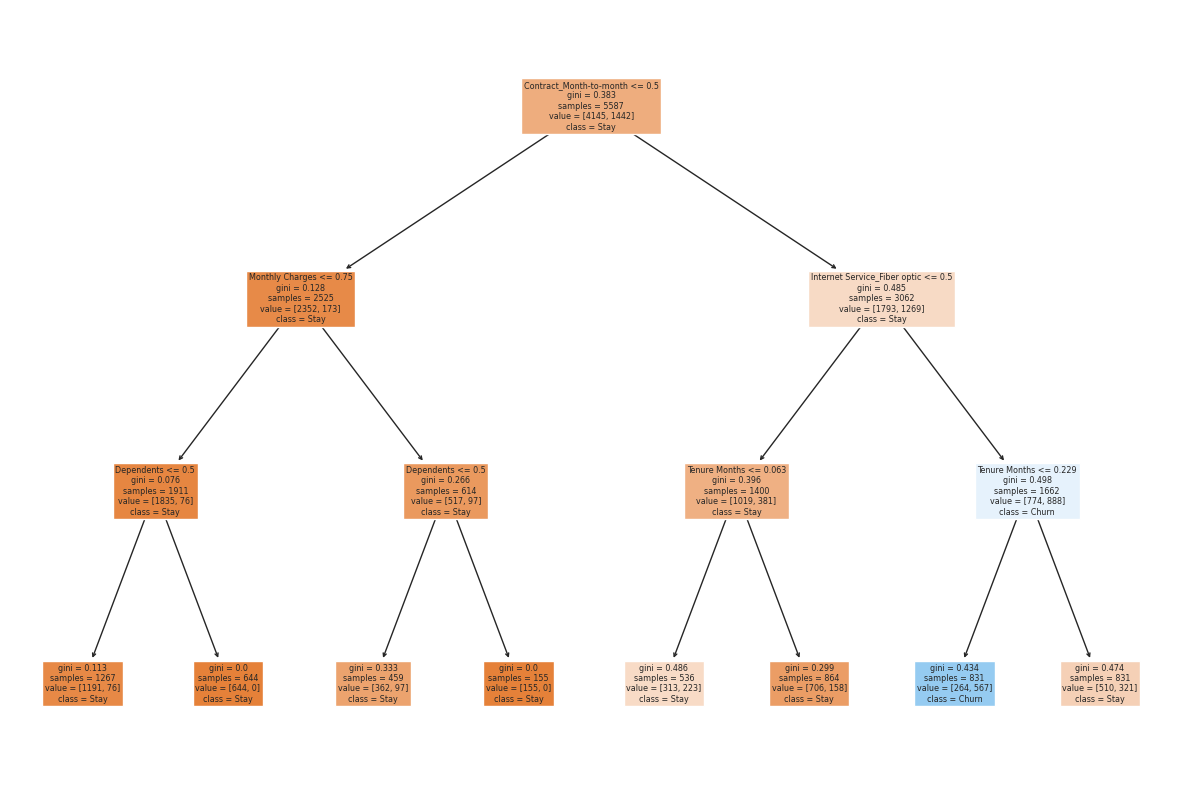

In [ ]:
# Plot to visualise tree
fig = plt.figure(figsize=(15,10))
tree_1 = tree.plot_tree(treeclf,
                   feature_names=model_features,
                   class_names=["Stay", "Churn"],
                   filled=True)

In [ ]:
# Evaluate on train and test

print(f'Score on training set: {treeclf.score(X_train_fe[model_features], y_train)}')
print(f'Score on testing set: {treeclf.score(X_test_fe[model_features], y_test)}')

Score on training set: 0.7961338822265974
Score on testing set: 0.7874015748031497


## 5.2 Grid Search to Establish Best Model Parameters

In [ ]:
# Using cross validation and grid search to find best paramaters

grid = GridSearchCV(estimator = DecisionTreeClassifier(), # What is the algorithm/model to use?
                    param_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], # How many levels can I go down?
                                  'min_samples_split': [5, 10, 15, 20, 50, 100],
                                  'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                                  'max_features':[2, 5]}, # How many parameters can I use?
                    cv = 10, # How many splits
                    refit = True, # Do we refit the data on each run?
                    verbose = 1, # How much to tell us?
                    scoring = 'accuracy') # Which performance metric am I maximising?

In [ ]:
# Run the gridsearch

# Record the current time
now = time()

# Fit the gridsearch on Train
grid.fit(X_train_fe[model_features], y_train)

# Record the time when it stopped running
print(f' Time in seconds: {time() - now}')


Fitting 10 folds for each of 576 candidates, totalling 5760 fits
 Time in seconds: 74.0194239616394


In [ ]:
# Best model parameters
grid.best_params_

{'max_depth': 10,
 'max_features': 5,
 'min_samples_leaf': 7,
 'min_samples_split': 100}

In [ ]:
# Accuracy for best paramaters
grid.best_score_

0.8023999589641001

In [ ]:
# Best model
grid.best_estimator_

DecisionTreeClassifier(max_depth=10, max_features=5, min_samples_leaf=7,
                       min_samples_split=100)

In [ ]:
# Create best model and fit on train
dt = grid.best_estimator_

In [ ]:
dt.fit(X_train_fe[model_features], y_train)

DecisionTreeClassifier(max_depth=10, max_features=5, min_samples_leaf=7,
                       min_samples_split=100)

## 5.3 Generating Predictions

In [ ]:
# Evaluate model.
print(f'Score on training set: {dt.score(X_train_fe[model_features], y_train)}')
print(f'Score on testing set: {dt.score(X_test_fe[model_features], y_test)}')

Score on training set: 0.818686235904779
Score on testing set: 0.8024337866857552


In [ ]:
# Generate results on train
X_train_fe['y_pred2'] = dt.predict(X_train_fe[model_features])
X_train_fe['y_prob2'] = dt.predict_proba(X_train_fe[model_features])[:,1]

X_train_fe.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Total Charges,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,prob_stay1,prob_churn1,y_pred1,y_pred2,y_prob2
4371,6281-FKEWS,1,United States,California,Berry Creek,95916,"39.657228, -121.37778",39.657228,-121.377780,1,0,0,0,0.611111,0,1,0.306468,0.260800,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0.643852,0.356148,0,0,0.128205
2261,7495-OOKFY,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237,1,1,1,1,0.111111,1,1,0.620896,0.072921,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0.486857,0.513143,0,0,0.327273
5397,9978-HYCIN,1,United States,California,Bakersfield,93301,"35.383937, -119.020428",35.383937,-119.020428,0,1,1,1,0.652778,1,1,0.663682,0.462653,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0.844014,0.155986,0,0,0.000000
6194,3301-VKTGC,1,United States,California,Huron,93234,"36.217864, -120.080117",36.217864,-120.080117,0,0,1,1,0.944444,1,1,0.669154,0.655928,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0.933714,0.066286,0,0,0.000000
2169,4680-KUTAJ,1,United States,California,Beverly Hills,90212,"34.062095, -118.401508",34.062095,-118.401508,1,1,0,0,0.152778,1,1,0.371642,0.066875,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0.265690,0.734310,1,0,0.254237


In [ ]:
# Generate results on test
X_test_fe['y_pred2'] = dt.predict(X_test_fe[model_features])
X_test_fe['y_prob2'] = dt.predict_proba(X_test_fe[model_features])[:,1]

X_test_fe.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Total Charges,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,prob_stay1,prob_churn1,y_pred1,y_pred2,y_prob2
1859,4177-JPDFU,1,United States,California,Redcrest,95569,"40.363446, -123.835041",40.363446,-123.835041,0,0,0,0,0.166667,0,0,0.155611,0.051766,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0.587173,0.412827,0,0,0.260870
6978,9680-NIAUV,1,United States,California,West Hills,91307,"34.199787, -118.68493",34.199787,-118.684930,1,0,1,0,1.000000,1,0,0.910723,0.951112,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0.832471,0.167529,0,0,0.112676
1667,7542-CYDDM,1,United States,California,Turlock,95382,"37.529656, -120.854357",37.529656,-120.854357,0,0,0,0,0.250000,1,0,0.016459,0.041944,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0.707936,0.292064,0,0,0.129630
368,5047-LHVLY,1,United States,California,Los Angeles,90020,"34.066367, -118.309868",34.066367,-118.309868,0,1,0,0,0.013889,1,1,0.316708,0.005867,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0.236618,0.763382,1,1,0.569444
5372,8679-LZBMD,1,United States,California,North Fork,93643,"37.244307, -119.470256",37.244307,-119.470256,0,0,1,0,0.611111,1,1,0.720698,0.464968,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0.464410,0.535590,0,0,0.228261


## 5.4 Evaluating on Train

In [ ]:
train_scores = apr(X_train_fe['y_pred2'], y_train)

Accuracy:0.818686235904779
Precision:0.6777133388566694
Recall:0.5672676837725381
F1:0.61759154397886


## 5.5 Evaluating on Test

In [ ]:
test_scores = apr(X_test_fe['y_pred2'], y_test)

Accuracy:0.8024337866857552
Precision:0.636094674556213
Recall:0.5842391304347826
F1:0.6090651558073654


With an accuracy of 0.82 on train and 0.79 on test, this model is **overfit**. This is because of the greedy nature of decision trees. One way we can combat this is by using a **random forest** model.

# 6. Model 3: Sklearn Random Forest

## 6.1 Model Creation and Training

In [ ]:
rf = RandomForestClassifier(n_estimators=50) # creates a random forest classifier with 50 trees.

In [ ]:
rf_score = cross_val_score(rf, X_train_fe[model_features], y_train, cv=5) # cross validation scores with 5 folds

In [ ]:
print(f'Random scored {rf_score}')

Random scored [0.79785331 0.80053667 0.79677708 0.80214861 0.7905103 ]


## 6.2 Grid Search to Establish Best Model Parameters

In [ ]:
rf_params = {
    'n_estimators': [50, 100, 150], # how many trees?
    'max_depth': [1, 2, 3, 4, 5], # how many levels per tree?
}


gs = GridSearchCV(rf, param_grid=rf_params, cv=5) # grid search on rf_params

gs.fit(X_train_fe[model_features], y_train) # fit to training data

print(gs.best_score_)

gs.best_params_

0.8050854976673719


{'max_depth': 5, 'n_estimators': 50}

## 6.3 Generating Predictions


In [ ]:
# Calculating probabilities on X_train
X_train_fe[['prob_stay3', 'prob_churn3']] = gs.predict_proba(X_train_fe[model_features])

In [ ]:
# Make predictions using cut-off point
X_train_fe['y_pred3'] = np.where(X_train_fe['prob_churn3']>0.5, 1, 0) #condition
X_train_fe.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Total Charges,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,prob_stay1,prob_churn1,y_pred1,y_pred2,y_prob2,prob_stay3,prob_churn3,y_pred3
4371,6281-FKEWS,1,United States,California,Berry Creek,95916,"39.657228, -121.37778",39.657228,-121.377780,1,0,0,0,0.611111,0,1,0.306468,0.260800,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0.643852,0.356148,0,0,0.128205,0.845693,0.154307,0
2261,7495-OOKFY,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237,1,1,1,1,0.111111,1,1,0.620896,0.072921,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0.486857,0.513143,0,0,0.327273,0.551368,0.448632,0
5397,9978-HYCIN,1,United States,California,Bakersfield,93301,"35.383937, -119.020428",35.383937,-119.020428,0,1,1,1,0.652778,1,1,0.663682,0.462653,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0.844014,0.155986,0,0,0.000000,0.925720,0.074280,0
6194,3301-VKTGC,1,United States,California,Huron,93234,"36.217864, -120.080117",36.217864,-120.080117,0,0,1,1,0.944444,1,1,0.669154,0.655928,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0.933714,0.066286,0,0,0.000000,0.937359,0.062641,0
2169,4680-KUTAJ,1,United States,California,Beverly Hills,90212,"34.062095, -118.401508",34.062095,-118.401508,1,1,0,0,0.152778,1,1,0.371642,0.066875,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0.265690,0.734310,1,0,0.254237,0.649193,0.350807,0


## 6.4 Evaluating on Train


In [ ]:
# Using APR function as above
apr(X_train_fe['y_pred3'], y_train)

Accuracy:0.8097368892070879
Precision:0.7200929152148664
Recall:0.42995839112343964
F1:0.5384281372123317


(0.8097368892070879,
 0.7200929152148664,
 0.42995839112343964,
 0.5384281372123317)

## 6.5 Evaluating on Test

In [ ]:
# Calculating probabilities on X_test
X_test_fe[['prob_stay3', 'prob_churn3']] = gs.predict_proba(X_test_fe[model_features])

In [ ]:
# Make predictions using cut-off point
X_test_fe['y_pred3'] = np.where(X_test_fe['prob_churn3']>0.5, 1, 0) #condition

In [ ]:
# Using APR function as above
apr(X_test_fe['y_pred3'], y_test)

Accuracy:0.8010021474588404
Precision:0.67578125
Recall:0.4701086956521739
F1:0.5544871794871795


(0.8010021474588404, 0.67578125, 0.4701086956521739, 0.5544871794871795)

With an accuracy on train and test of 0.810 and 0.809 respectively, this model is far more **robust** than it's predecessor.

# 7. Model 4: Tensorflow Random Forest

## 7.1 Installing tensorflow decision forests

In [ ]:
## Install tensorflow_decision_forests
!pip install tensorflow_decision_forests ;

In [ ]:
## Import required modules for tensorflow and class imbalance
import tensorflow_decision_forests as tfdf
from imblearn.over_sampling import SMOTE

## 7.2 Feature Engineering and Selection

In [ ]:
# Feature engineering to get the column names to work with Tensorflow:
# Remove the white spaces and replace with underscores

def replace_spaces(df):
  '''Replace white spaces in column names with underscores.'''
  df = df.copy()
  df.columns = df.columns.str.replace(' ', '_')
  return df

In [ ]:
# Apply the feature engineering to the dataframe
df_fe_ = feature_eng(df)
df_ = replace_spaces(df_fe_)

In [ ]:
# Select features & target: these are the same features as in Section 3.5, but with underscores instead of spaces

features_ = ['Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Paperless_Billing', 'Monthly_Charges', 'Total_Charges',
       'Multiple_Lines_No', 'Multiple_Lines_Yes',
       'Online_Security_No', 'Online_Security_Yes', 'Online_Backup_No', 'Online_Backup_Yes',
       'Device_Protection_No', 'Device_Protection_Yes', 'Tech_Support_No',
       'Tech_Support_Yes', 'Streaming_TV_No', 'Streaming_TV_Yes', 'Streaming_Movies_No',
       'Streaming_Movies_Yes',
       'Internet_Service_Fiber_optic', 'Internet_Service_No',
       'Contract_Month-to-month', 'Contract_One_year', 'Contract_Two_year',
       'Payment_Method_Credit_card_(automatic)',
       'Payment_Method_Electronic_check', 'Payment_Method_Mailed_check']

y_ = df_['Churn_Value']
X_ = df_[features_]

In [ ]:
# Checking columns in X
X_.columns

Index(['Latitude', 'Longitude', 'Gender', 'Senior_Citizen', 'Partner',
       'Dependents', 'Tenure_Months', 'Phone_Service', 'Paperless_Billing',
       'Monthly_Charges', 'Total_Charges', 'Multiple_Lines_No',
       'Multiple_Lines_Yes', 'Online_Security_No', 'Online_Security_Yes',
       'Online_Backup_No', 'Online_Backup_Yes', 'Device_Protection_No',
       'Device_Protection_Yes', 'Tech_Support_No', 'Tech_Support_Yes',
       'Streaming_TV_No', 'Streaming_TV_Yes', 'Streaming_Movies_No',
       'Streaming_Movies_Yes', 'Internet_Service_Fiber_optic',
       'Internet_Service_No', 'Contract_Month-to-month', 'Contract_One_year',
       'Contract_Two_year', 'Payment_Method_Credit_card_(automatic)',
       'Payment_Method_Electronic_check', 'Payment_Method_Mailed_check'],
      dtype='object')

## 7.3 Train Test Splitting

In [ ]:
# Train-test split the data, then bring back the targets because TFDF doesn't need the features split apart from the target:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=.2, random_state=1204, stratify=y)

## 7.4 Using SMOTE to address Class Imbalance

In [ ]:
# Using SMOTE to oversample the data to address class imbalance
# Instantiate SMOTE
smote = SMOTE()

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_, y_train_)

In [ ]:
# Adding the target back in for TFDF
X_train_resampled['Churn_Value'] = y_train_resampled
X_test_['Churn_Value'] = y_test_

In [ ]:
X_train_.head()

,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Paperless_Billing,Monthly_Charges,Total_Charges,Multiple_Lines_No,Multiple_Lines_Yes,Online_Security_No,Online_Security_Yes,Online_Backup_No,Online_Backup_Yes,Device_Protection_No,Device_Protection_Yes,Tech_Support_No,Tech_Support_Yes,Streaming_TV_No,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_Yes,Internet_Service_Fiber_optic,Internet_Service_No,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
7042,33.782068,-118.262263,0,0,0,1,0.000000,1,1,0.434328,0.000000,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0
47,37.023669,-121.946461,0,0,0,0,0.013889,1,0,0.013930,0.002263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4451,33.868316,-117.929029,0,0,1,0,0.583333,1,0,0.376617,0.274831,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0
1087,33.865320,-118.396336,1,1,1,0,0.027778,1,0,0.606468,0.019903,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0
2237,39.237540,-120.720196,1,0,0,0,0.319444,1,0,0.065174,0.070854,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0


## 7.5 Converting to Datasets

In [ ]:
# Work with datasets instead of dataframes to optimise runtime
# this is why we were able to bring the label/target back to the dataframe
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train_resampled, label = 'Churn_Value', fix_feature_names=False)

In [ ]:
# Checking that train_ds is indeed a dataset
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

## 7.6 Model Creation and Training

In [ ]:
# Initialising and fitting the model
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)

Use /tmp/tmponykb_fq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:11.376343. Found 8278 examples.
Training model...
Model trained in 0:00:18.686935
Compiling model...
Model compiled.


In [ ]:
# Make the test df into a dataset too
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test_, label = 'Churn_Value', fix_feature_names=False)

In [ ]:
# Compile the model, focus on 'accuracy' as the primary metric
model.compile(metrics=["accuracy"])

In [ ]:
# Evaluate model performance on the train data
model.evaluate(train_ds)

9/9 [==============================] - 2s 89ms/step - loss: 0.0000e+00 - accuracy: 0.9404


[0.0, 0.9404445290565491]

In [ ]:
# Evaluate the model performance on the test data
print(model.evaluate(test_ds))

2/2 [==============================] - 1s 36ms/step - loss: 0.0000e+00 - accuracy: 0.7888
[0.0, 0.7888332009315491]


In [ ]:
## Visuals of the tensorflow process
tfdf.model_plotter.plot_model_in_colab(model,
                                       tree_idx=0) # specifying which tree we're visualising

## 7.7 Model Summary

In [ ]:
## Lastly, one of the major advantages of Tensorflow: Comprehensive summary
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (33):
	Contract_Month-to-month
	Contract_One_year
	Contract_Two_year
	Dependents
	Device_Protection_No
	Device_Protection_Yes
	Gender
	Internet_Service_Fiber_optic
	Internet_Service_No
	Latitude
	Longitude
	Monthly_Charges
	Multiple_Lines_No
	Multiple_Lines_Yes
	Online_Backup_No
	Online_Backup_Yes
	Online_Security_No
	Online_Security_Yes
	Paperless_Billing
	Partner
	Payment_Method_Credit_card_(automatic)
	Payment_Method_Electronic_check
	Payment_Method_Mailed_check
	Phone_Service
	Senior_Citizen
	Streaming_Movies_No
	Streaming_Movies_Yes
	Streaming_TV_No
	Streaming_TV_Yes
	Tech_Support_No
	Tech

## 7.8 Tensorflow Model Finetuning

In [ ]:
# Using the built-in tuner to optimise the model for TFDF
tuner = tfdf.tuner.RandomSearch(num_trials=20)

In [ ]:
# Fit the improved model
model_2 = tfdf.keras.RandomForestModel(tuner=tuner)
model_2.fit(train_ds)

Use /tmp/tmpp9fe_v5o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.498054. Found 8278 examples.
Training model...
Model trained in 0:00:11.497061
Compiling model...
Model compiled.


## 7.9 Evaluating on Train and Test

In [ ]:
## Evaluate improved model on train
model_2.compile(metrics=['accuracy'])
print(model_2.evaluate(train_ds))

9/9 [==============================] - 1s 57ms/step - loss: 0.0000e+00 - accuracy: 0.9404
[0.0, 0.9404445290565491]


In [ ]:
## Evaluate improved model on test
model_2.compile(metrics=["accuracy"])
print(model_2.evaluate(test_ds))

2/2 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 0.7888
[0.0, 0.7888332009315491]


The large reduction in accuracy between train and test tells us that while Tensorflow is a useful tool for creating a random forest model, this particular model is **highly overtrained**.
> This is a good argument for using Sklearn over Tensorflow in it's current state - Sklearn lets us manually change parameters in order to more easily fix issues such as this.

# 8. Drawing Insights

After evaluating our four models we determined that the **logistic regression** model and **random forest** (Sklearn)  model were the most robust and accurate models we had created. Hence, we decided to combine these two models to predict the **top 500 customers** most likely to leave and the probability of churning for all remaining customers.
> Since both these models have very similiar accuracy, we created an **unweighted average** of the predicted proabilities and used this average to create our lists.


## 8.1 Creating a list of top 500 customers most likely to churn


In [ ]:
not_churned = df_fe[df_fe['Churn Value'] == 0] # create a new df with only existing customers

In [ ]:
def top_500_2(models, features):
    df_probs = pd.DataFrame()  # empty dataframe
    df_probs['CustomerID'] = not_churned['CustomerID']  # create a customer ID column


    prob_columns = [f'prob_churn_{i}' for i in range(len(models))] # loops through each model
    for i in range(len(models)):
        model = models[i]
        df_probs[f'prob_churn_{i}'] = model.predict_proba(not_churned[features])[:, 1] # Calculates prob of Churn


    df_probs['avg_prob_churn'] = df_probs[prob_columns].mean(axis=1)   # Calculate the average probability across models

    # Select top 500 customers based on average probability of churning
    df_probs_500 = df_probs.sort_values(by='avg_prob_churn', ascending=False).head(500)

    return df_probs_500

In [ ]:
# Create a list with probabilities averaged over both models
top_500_list = top_500_2([gs,logreg], model_features)


In [ ]:
# Makes list into a csv file
top_500_list['CustomerID'].to_csv('top_500_customers.csv', index=False)

## 8.2 Probability of churning for all remaining customers

In [ ]:
def churn_likelihood(models, top_500, features):
    df_probs = pd.DataFrame()  # empty dataframe

    merged_df = pd.merge(not_churned, top_500, on='CustomerID', how='left')  # merge the top 500 df with the df containing all customers who have not churned

    new_df = merged_df[merged_df['avg_prob_churn'].isnull()]  # filter the database to remove all customers who were present in the top 500 list
    df_probs[['CustomerID']] = new_df[['CustomerID']]  #

    avg_prob_churn = np.zeros(len(new_df))  # Initialize an array to store the average probability of churning for each customer

    for model in models:
        prob_churn = model.predict_proba(new_df[features])[:, 1]  # Predict probability of churning using the current model
        avg_prob_churn += prob_churn  # Accumulate probabilities across all models

    avg_prob_churn /= len(models)  # Calculate the average probability of churning across all models

    df_probs['avg_prob_churn'] = avg_prob_churn  # Create a column for the average probability of churning

    df_churn_likelihood = df_probs.sort_values(by='avg_prob_churn', ascending=False)  # order by max average probability of churning
    return df_churn_likelihood

In [ ]:
# Creates a list of all remaining customers with churn probability averaged over both models
churn_probs = churn_likelihood([gs,logreg], top_500_list, model_features)
churn_probs

,CustomerID,avg_prob_churn
3605,5144-TVGLP,0.598758
1491,4522-AKYLR,0.598248
2380,2507-QZPQS,0.598232
557,4137-BTIKL,0.598200
3252,5222-IMUKT,0.598186
...,...,...
2277,6928-ONTRW,0.006525
2410,0640-YJTPY,0.006484
2551,9365-CSLBQ,0.006473
2312,0794-YVSGE,0.006444


In [ ]:
# Make list into a csv file
churn_probs.to_csv('churn_risk.csv', index=False)

## 8.3 Feature Importance

Information taken from Model 2 - Decision Tree

In [ ]:
# List features by importance
list(zip(model_features, dt.feature_importances_))

[('Contract_Month-to-month', 0.1160470129945869),
 ('Online Security_No', 0.03782854841225111),
 ('Tenure Months', 0.21747864376343284),
 ('Tech Support_No', 0.3154248593061925),
 ('Internet Service_Fiber optic', 0.033695338772917714),
 ('Contract_Two year', 0.0),
 ('Payment Method_Electronic check', 0.024831688415904267),
 ('Online Backup_No', 0.0018646152287285051),
 ('Device Protection_No', 0.0),
 ('Dependents', 0.0835999718500731),
 ('Internet Service_No', 0.004106861688960916),
 ('Total Charges', 0.058833489650845755),
 ('Monthly Charges', 0.07523931416881002),
 ('Paperless Billing', 0.009749249116658839),
 ('Contract_One year', 0.007536845571747924),
 ('Online Security_Yes', 0.002937587793527612),
 ('Tech Support_Yes', 0.007374633974282408),
 ('Senior Citizen', 0.001046268809345798),
 ('Partner', 0.0024050704817337922)]

## 8.4 Demographics of Churners

### 8.41 Gender

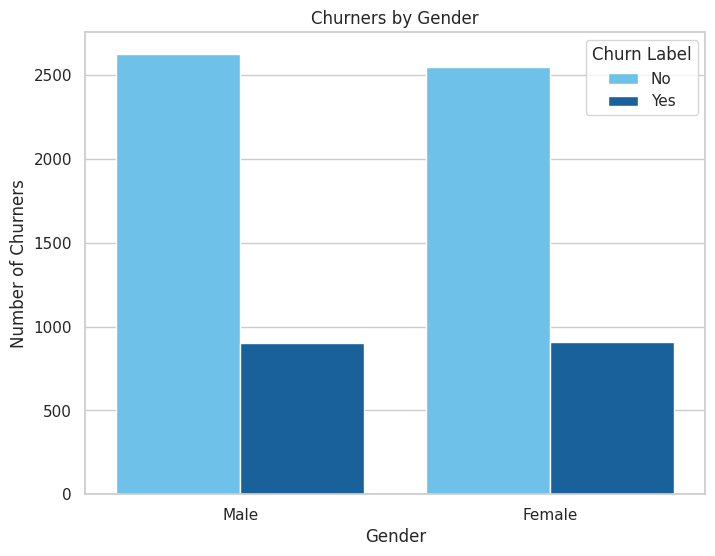

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn's countplot to create a bar graph
sns.countplot(x="Gender", hue="Churn Label", data=df, palette={'Yes': '#0263b0', 'No': '#5acafd'})

# Add labels and title
plt.title('Churners by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Churners')

# Show the plot
plt.show()

In [ ]:
# Percentage of Churners by Gender
df_female = df[df['Gender']=='Female']
df_female['Churn Value'].value_counts(normalize=True)

0    0.736918
1    0.263082
Name: Churn Value, dtype: float64

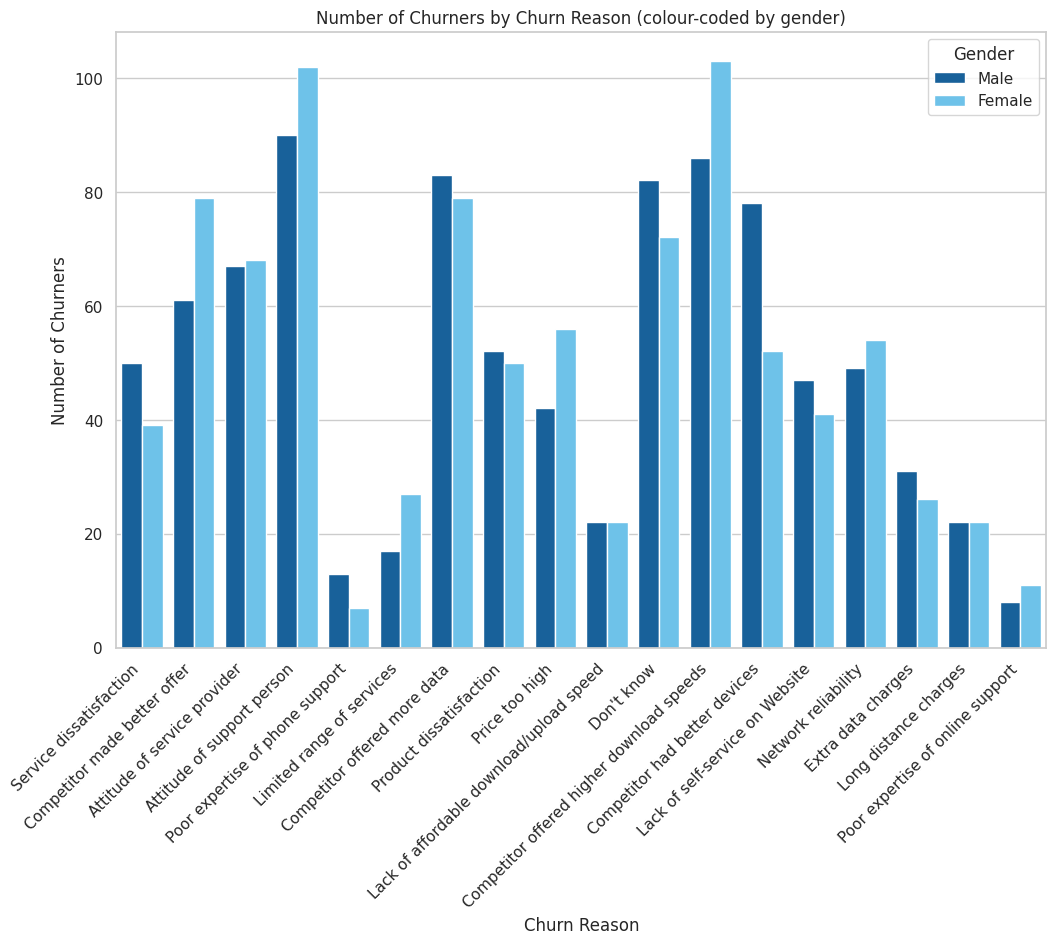

In [ ]:
plt.figure(figsize=(12, 8))

# Filter DataFrame for churners
churners_df = df[df['Churn Label'] == 'Yes']

# Use Seaborn's countplot to create a bar chart
sns.countplot(x="Churn Reason", hue="Gender", data=churners_df, palette={'Male': '#0263b0', 'Female': '#5acafd'})

# Add labels and title
plt.title('Number of Churners by Churn Reason (colour-coded by gender)')
plt.xlabel('Churn Reason')
plt.ylabel('Number of Churners')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

### 8.42 Age

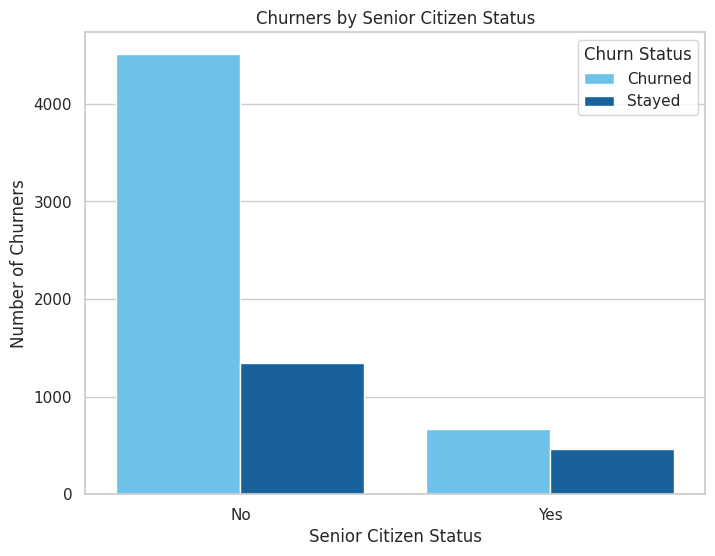

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn's countplot to create a bar graph
sns.countplot(x="Senior Citizen", hue="Churn Label", data=df, palette={'Yes': '#0263b0', 'No': '#5acafd'})

# Add labels and title
plt.title('Churners by Senior Citizen Status')
plt.xlabel('Senior Citizen Status')
plt.ylabel('Number of Churners')

plt.legend(title='Churn Status', labels=['Churned', 'Stayed'])

# Show the plot
plt.show()

In [ ]:
# Percentage of Churners by Age
df_senior = df[df['Senior Citizen']=='Yes']
df_senior['Churn Value'].value_counts(normalize=True)

0    0.588339
1    0.411661
Name: Churn Value, dtype: float64

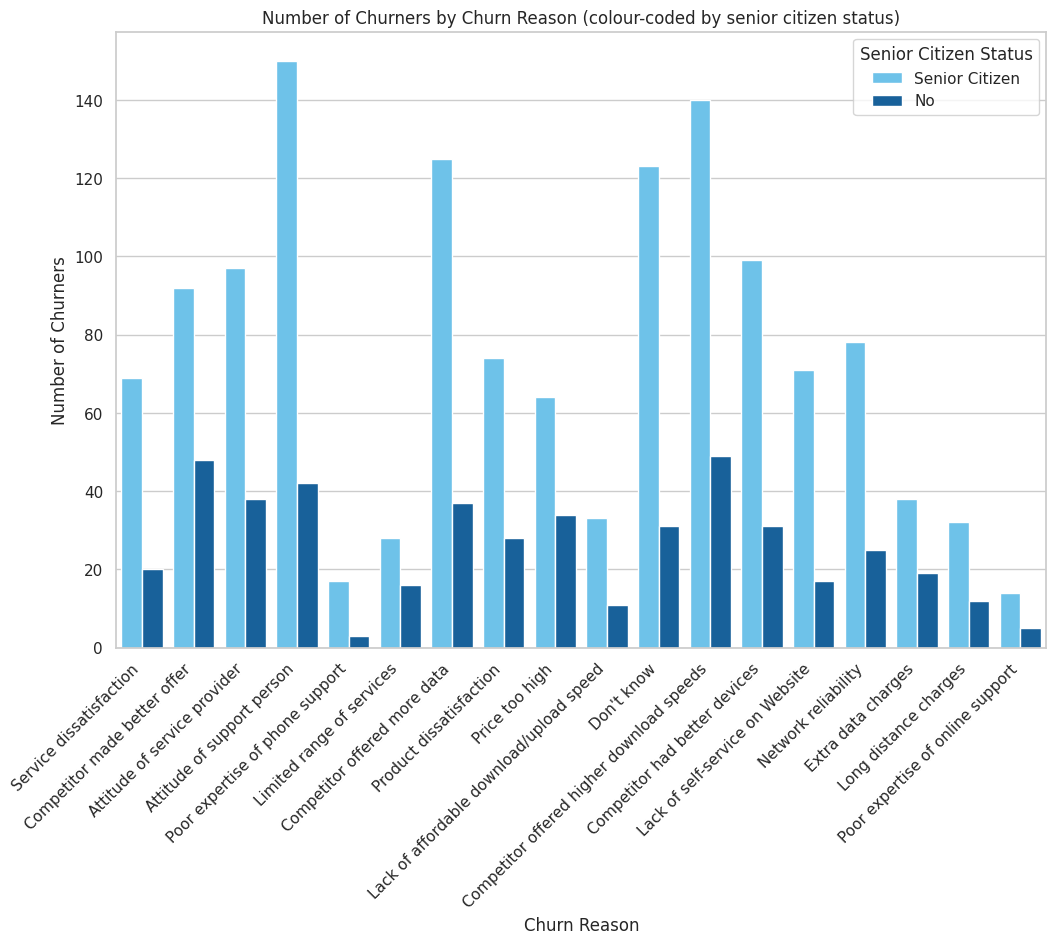

In [ ]:
plt.figure(figsize=(12, 8))

# Filter DataFrame for churners
churners_df = df[df['Churn Label'] == 'Yes']

# Use Seaborn's countplot to create a bar chart
sns.countplot(x="Churn Reason", hue="Senior Citizen", data=churners_df, palette={'Yes': '#0263b0', 'No': '#5acafd'})

# Add labels and title
plt.title('Number of Churners by Churn Reason (colour-coded by senior citizen status)')
plt.xlabel('Churn Reason')
plt.ylabel('Number of Churners')
plt.legend(title='Senior Citizen Status', labels=['Senior Citizen', 'No'])

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

> The churn reason most common among Senior Citizens is 'Attitude of Support Person'.

### 8.43 Partner status

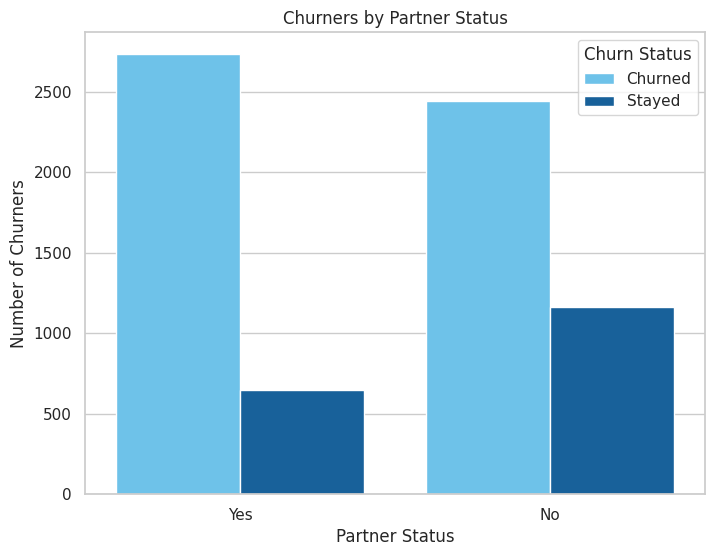

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn's countplot to create a bar graph
sns.countplot(x="Partner", hue="Churn Label", data=df, palette={'Yes': '#0263b0', 'No': '#5acafd'})
# Add labels and title
plt.title('Churners by Partner Status')
plt.xlabel('Partner Status')
plt.ylabel('Number of Churners')

plt.legend(title='Churn Status', labels=['Churned', 'Stayed'])

# Show the plot
plt.show()

In [ ]:
# Percentage of Churners by Partner Status
df_partner = df[df['Partner']=='No']
df_partner['Churn Value'].value_counts(normalize=True)

0    0.676927
1    0.323073
Name: Churn Value, dtype: float64

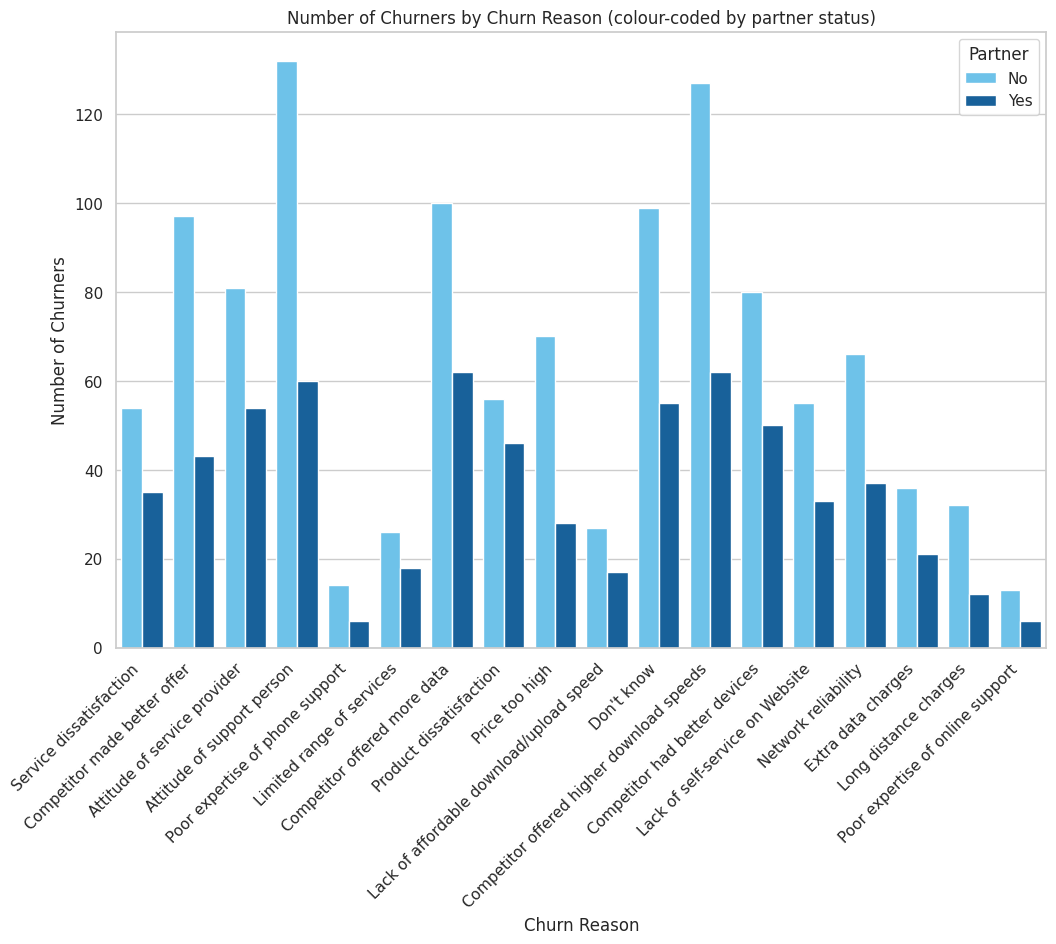

In [ ]:
plt.figure(figsize=(12, 8))

# Filter DataFrame for churners
churners_df = df[df['Churn Label'] == 'Yes']

# Use Seaborn's countplot to create a bar chart
sns.countplot(x="Churn Reason", hue="Partner", data=churners_df, palette={'Yes': '#0263b0', 'No': '#5acafd'})

# Add labels and title
plt.title('Number of Churners by Churn Reason (colour-coded by partner status)')
plt.xlabel('Churn Reason')
plt.ylabel('Number of Churners')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

### 8.44 Dependents Status

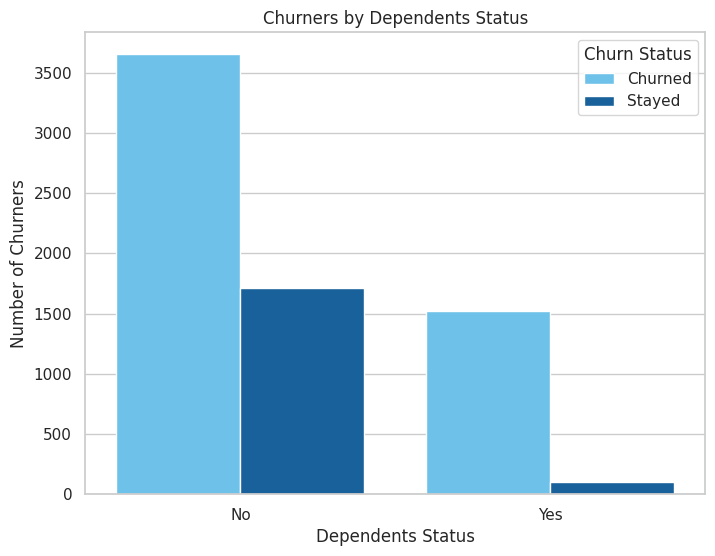

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn's countplot to create a bar graph
sns.countplot(x="Dependents", hue="Churn Label", data=df, palette={'Yes': '#0263b0', 'No': '#5acafd'})

# Add labels and title
plt.title('Churners by Dependents Status')
plt.xlabel('Dependents Status')
plt.ylabel('Number of Churners')

plt.legend(title='Churn Status', labels=['Churned', 'Stayed'])

# Show the plot
plt.show()

In [ ]:
# Percentage of Churners by Dependents Status
df_dep = df[df['Dependents']=='No']
df_dep['Churn Value'].value_counts(normalize=True)

0    0.681276
1    0.318724
Name: Churn Value, dtype: float64

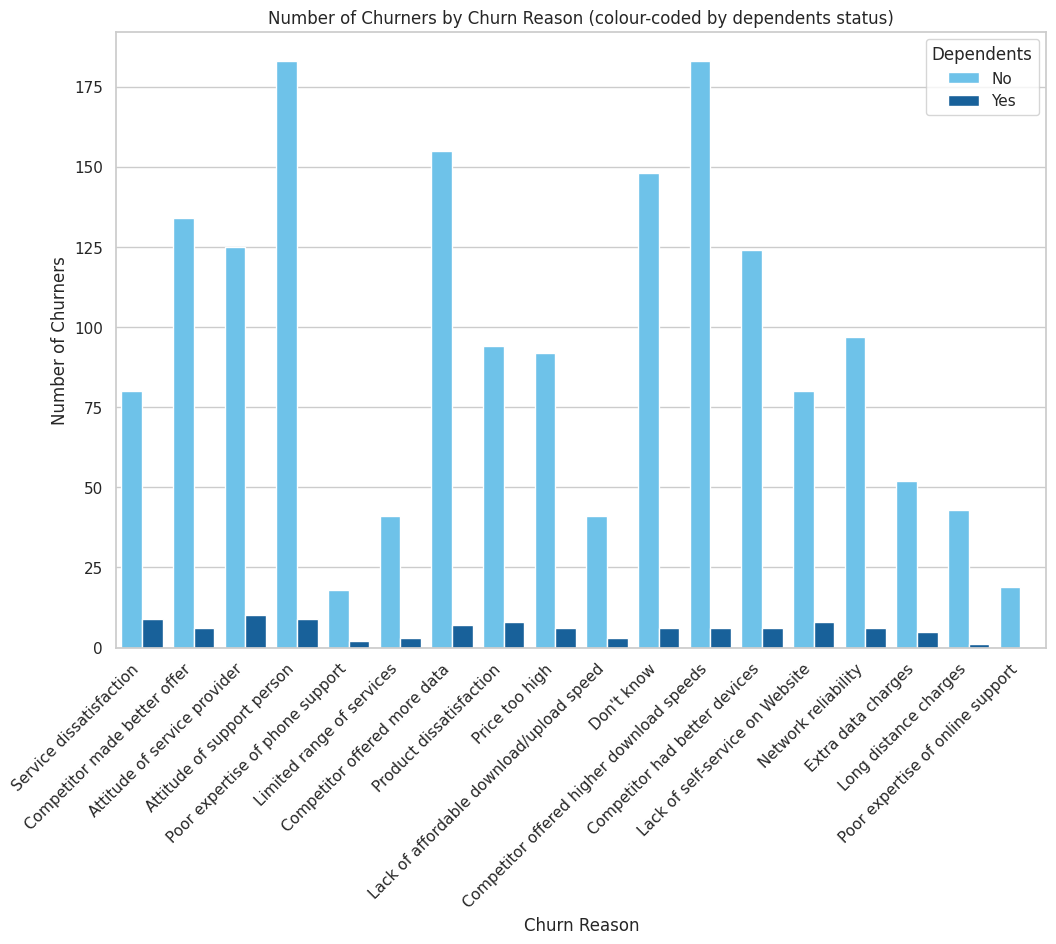

In [ ]:
plt.figure(figsize=(12, 8))

# Filter DataFrame for churners
churners_df = df[df['Churn Label'] == 'Yes']

# Use Seaborn's countplot to create a bar chart
sns.countplot(x="Churn Reason", hue="Dependents", data=churners_df, palette={'Yes': '#0263b0', 'No': '#5acafd'})

# Add labels and title
plt.title('Number of Churners by Churn Reason (colour-coded by dependents status)')
plt.xlabel('Churn Reason')
plt.ylabel('Number of Churners')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()